<a href="https://colab.research.google.com/github/Charan6924/Deep-Learning/blob/main/PytorchMLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('/content/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
block_size = 3

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte,  Yte  = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

12097


In [6]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)

  for p in parameters:
    p.grad = None
  loss.backward()

  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


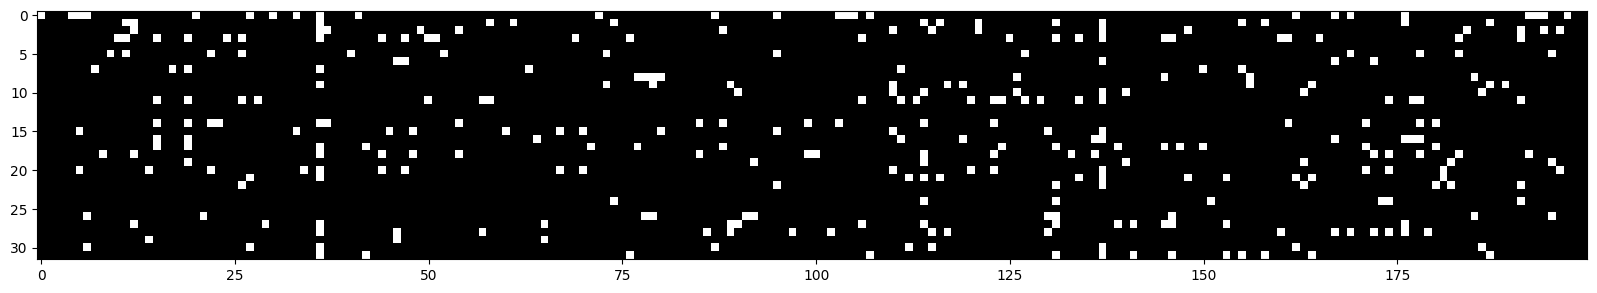

In [7]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap = 'gray', interpolation='nearest')


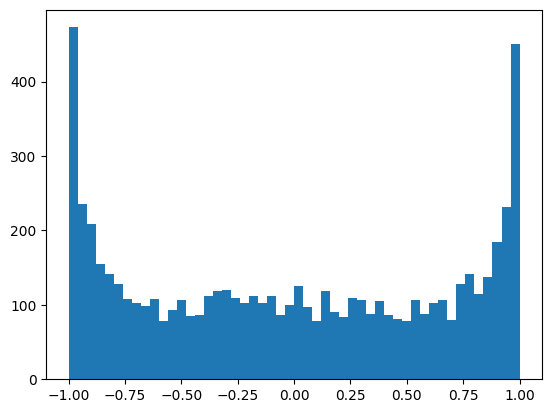

In [8]:
plt.hist(h.view(-1).tolist(),50);

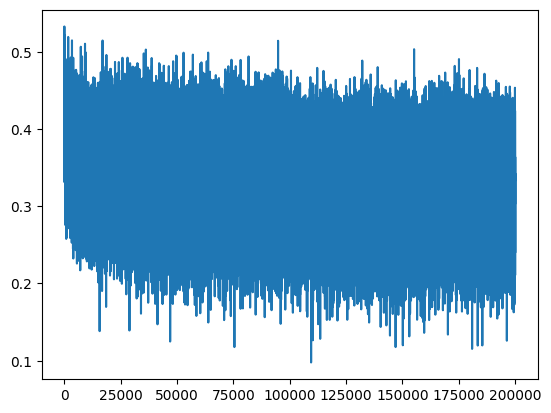

In [9]:
plt.plot(lossi)

In [10]:
with torch.no_grad():
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [11]:
@torch.no_grad()
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0674147605895996
val 2.1056840419769287


In [17]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 #kaiming
    self.bias = torch.zeros(fan_out) if bias else None # no need of bias if batch normalisation

  def __call__(self, x):
    self.out = x @ self.weight # wx
    if self.bias is not None:
      self.out += self.bias # + b
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias]) # parameters

In [13]:
class BatchNorm1d:
  def __init__(self, dim, eps = 1e-5, momentum = 0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    self.running_mean = torch.zeros((dim))
    self.running_var = torch.ones((dim))
    self.gamma = torch.ones((dim))
    self.beta = torch.zeros((dim))

  def __call__(self,x):
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean)/torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta
    if self.training:
      with torch.no_grad():
        self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

In [14]:
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [15]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

In [18]:
C = torch.randn((vocab_size, n_embd),generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

In [19]:
with torch.no_grad():
  layers[-1].gamma *= 0.1
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0

In [20]:
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

47024


In [22]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  emb = C[Xb]
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb)

  for layer in layers:
    layer.out.retain_grad()
  for p in parameters:
    p.grad = None
  loss.backward()

  lr = 0.1 if i < 150000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad # updating gradients

  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  #if i >= 1000:
    #break

      0/ 200000: 3.2954
  10000/ 200000: 2.2311
  20000/ 200000: 2.4035
  30000/ 200000: 2.1766
  40000/ 200000: 1.9736
  50000/ 200000: 2.3403
  60000/ 200000: 2.1756
  70000/ 200000: 2.0554
  80000/ 200000: 2.1631
  90000/ 200000: 2.0974
 100000/ 200000: 2.0421
 110000/ 200000: 1.7754
 120000/ 200000: 2.2092
 130000/ 200000: 1.9511
 140000/ 200000: 1.9524
 150000/ 200000: 2.0965
 160000/ 200000: 1.8380
 170000/ 200000: 2.0027
 180000/ 200000: 2.0579
 190000/ 200000: 2.0408


layer 2 (      Tanh): mean -0.00, std 0.69, saturated: 18.31%
layer 5 (      Tanh): mean -0.02, std 0.74, saturated: 20.62%
layer 8 (      Tanh): mean +0.00, std 0.78, saturated: 19.84%
layer 11 (      Tanh): mean +0.01, std 0.79, saturated: 22.09%
layer 14 (      Tanh): mean -0.02, std 0.80, saturated: 26.63%


/tmp/ipython-input-2270791295.py:6: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))


Text(0.5, 1.0, 'activation distribution')

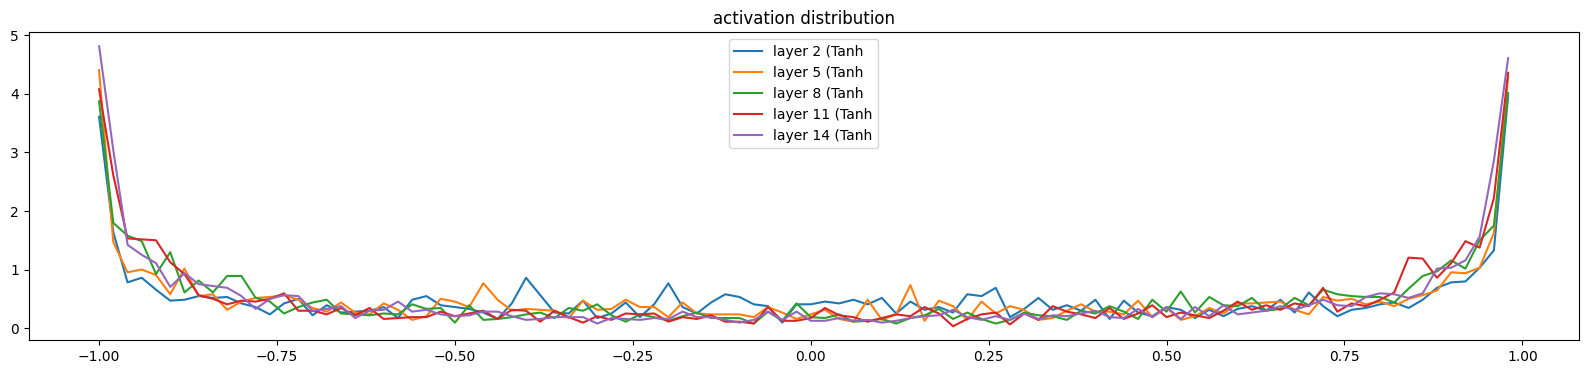

In [23]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 3.281083e-03
layer 5 (      Tanh): mean +0.000000, std 2.943018e-03
layer 8 (      Tanh): mean +0.000000, std 2.756124e-03
layer 11 (      Tanh): mean -0.000000, std 2.712761e-03
layer 14 (      Tanh): mean -0.000000, std 3.389028e-03


Text(0.5, 1.0, 'gradient distribution')

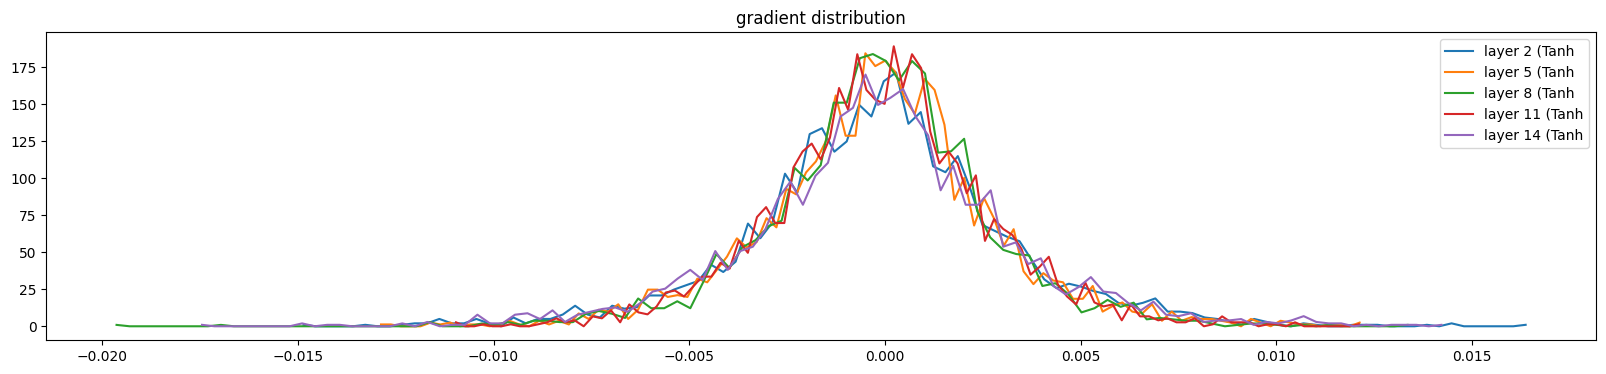

In [24]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 1.161148e-02 | grad:data ratio 1.048596e-02
weight  (30, 100) | mean +0.000189 | std 7.153771e-03 | grad:data ratio 1.778706e-02
weight (100, 100) | mean +0.000113 | std 4.174755e-03 | grad:data ratio 1.727122e-02
weight (100, 100) | mean -0.000025 | std 4.345699e-03 | grad:data ratio 1.825511e-02
weight (100, 100) | mean -0.000002 | std 4.155896e-03 | grad:data ratio 1.815969e-02
weight (100, 100) | mean +0.000051 | std 3.999943e-03 | grad:data ratio 1.864755e-02
weight  (100, 27) | mean -0.000011 | std 7.165923e-03 | grad:data ratio 2.047481e-02


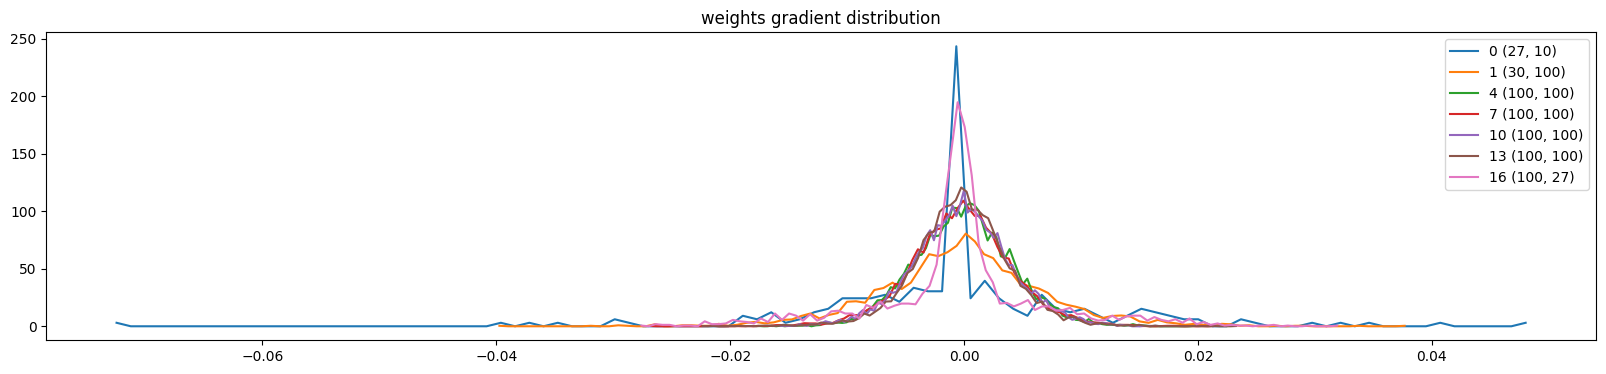

In [25]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

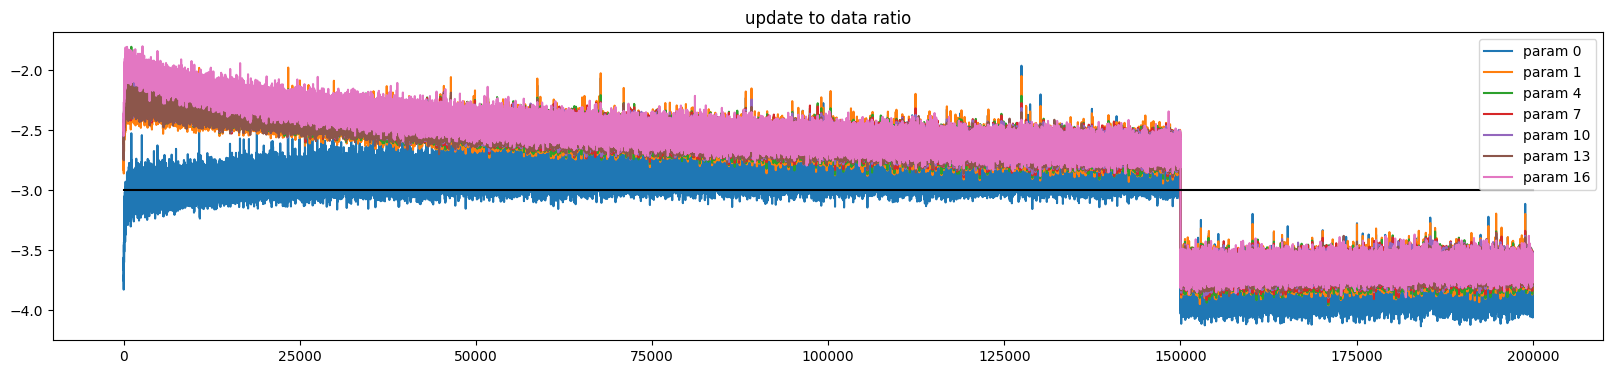

In [27]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.title('update to data ratio')
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);